# Module Importing

In [1]:
import os
os.chdir('..')

In [2]:
import datetime

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

# Data Loading

## Data fields
+ **ID** - an Id that represents a (Shop, Item) tuple within the test set
+ **shop_id** - unique identifier of a shop
+ **item_id** - unique identifier of a product
+ **item_category_id** - unique identifier of item category
+ **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
+ **item_price** - current price of an item
+ **date** - date in format dd/mm/yyyy
+ **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
+ **item_name** - name of item
+ **shop_name** - name of shop
+ **item_category_name** - name of item category

## Sales_train
**(the training set. Daily historical data from January 2013 to October 2015)**

In [30]:
sales_train_df = pd.read_csv('data/sales_train.csv')

In [31]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
print('Shape of sales_train.csv is (%d, %d)' % sales_train_df.shape)

Shape of sales_train.csv is (2935849, 6)


## Items
**(supplemental information about the items/products)**

In [11]:
items_df = pd.read_csv('data/items.csv')

In [12]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
print('Shape of items.csv is (%d, %d)' % items_df.shape)

Shape of items.csv is (22170, 3)


## Item_categories
**(supplemental information about the items categories)**

In [14]:
item_categories_df = pd.read_csv('data/item_categories.csv')

In [15]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
print('Shape of item_categories.csv is (%d, %d)' % item_categories_df.shape)

Shape of item_categories.csv is (84, 2)


## Shops
**(supplemental information about the shops)**

In [17]:
shops_df = pd.read_csv('data/shops.csv')

In [18]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [19]:
print('Shape of shops.csv is (%d, %d)' % shops_df.shape)

Shape of shops.csv is (60, 2)


## test
**(the test set. You need to forecast the sales for these shops and products for November 2015)**

In [20]:
test_df = pd.read_csv('data/test.csv')

In [21]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [22]:
print('Shape of test.csv is (%d, %d)' % test_df.shape)

Shape of test.csv is (214200, 3)


# Basic EDA

In [58]:
def intitial_eda_checks(df: pd.DataFrame) -> None:
    """
        1. Take a dataframe.
        2. Check if there is duplicates.
        3. Check if there is nulls.
    """

    # keep=False - marke all duplicates as True
    if len(df[df.duplicated(keep=False)]) > 0:
        print('- Number of duplicates = {}'.format(len(df[df.duplicated(keep=False)])))
    else:
        print('- No duplicates found.')

    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'- Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('- No NaN found.')

### Descriptive statistics, number of missing values, etc

**First and last 5 rows of DataFrame:**

In [48]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [49]:
sales_train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


**Basic information about a DataFrame:**

In [50]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [55]:
intitial_eda_checks(sales_train_df)

- Number of duplicates - 12
- No NaN found.


In [67]:
print('- Number of unique items = ',
      len(sales_train_df['item_id'].unique()))
print('- Number of unique items, which appears only once  = ',
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1]))
print('- Number of unique items, which appears less or equal than 10 times  = ', 
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() < 10]))

- Number of unique items =  21807
- Number of unique items, which appears only once  =  2371
- Number of unique items, which appears less than 10 times  =  6541


In [76]:
print('- Number of unique shops = ',
      len(sales_train_df['shop_id'].unique()))
print('- Number of unique shops, which appears only once  = ',
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() == 1]))
print('- Number of unique shops, which appears less or equal than 10000 times  = ', 
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() < 10000]))

- Number of unique shops =  60
- Number of unique shops, which appears only once  =  0
- Number of unique shops, which appears less or equal than 10000 times  =  12


In [65]:
len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1])

2371

**Top-10 popular items:**

In [114]:
top_10_items = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id')['item_name'].value_counts()[:50]).reset_index()
top_10_items.columns = ['item_name', 'count']

In [115]:
top_10_items.head(10)

,item_name,count
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31340
1,Playstation Store пополнение бумажника: Карта ...,9408
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7479
4,Kaspersky Internet Security Multi-Device Russi...,6853
5,World of Warcraft. Карта оплаты игрового време...,6602
6,"Grand Theft Auto V [PS3, русские субтитры]",6475
7,"Call of Duty: Black Ops II [PС, Jewel, русская...",6320
8,"Minecraft [Xbox 360, английская версия]",5811
9,"Grand Theft Auto V [Xbox 360, русские субтитры]",5805


Text(0.5, 0, '')

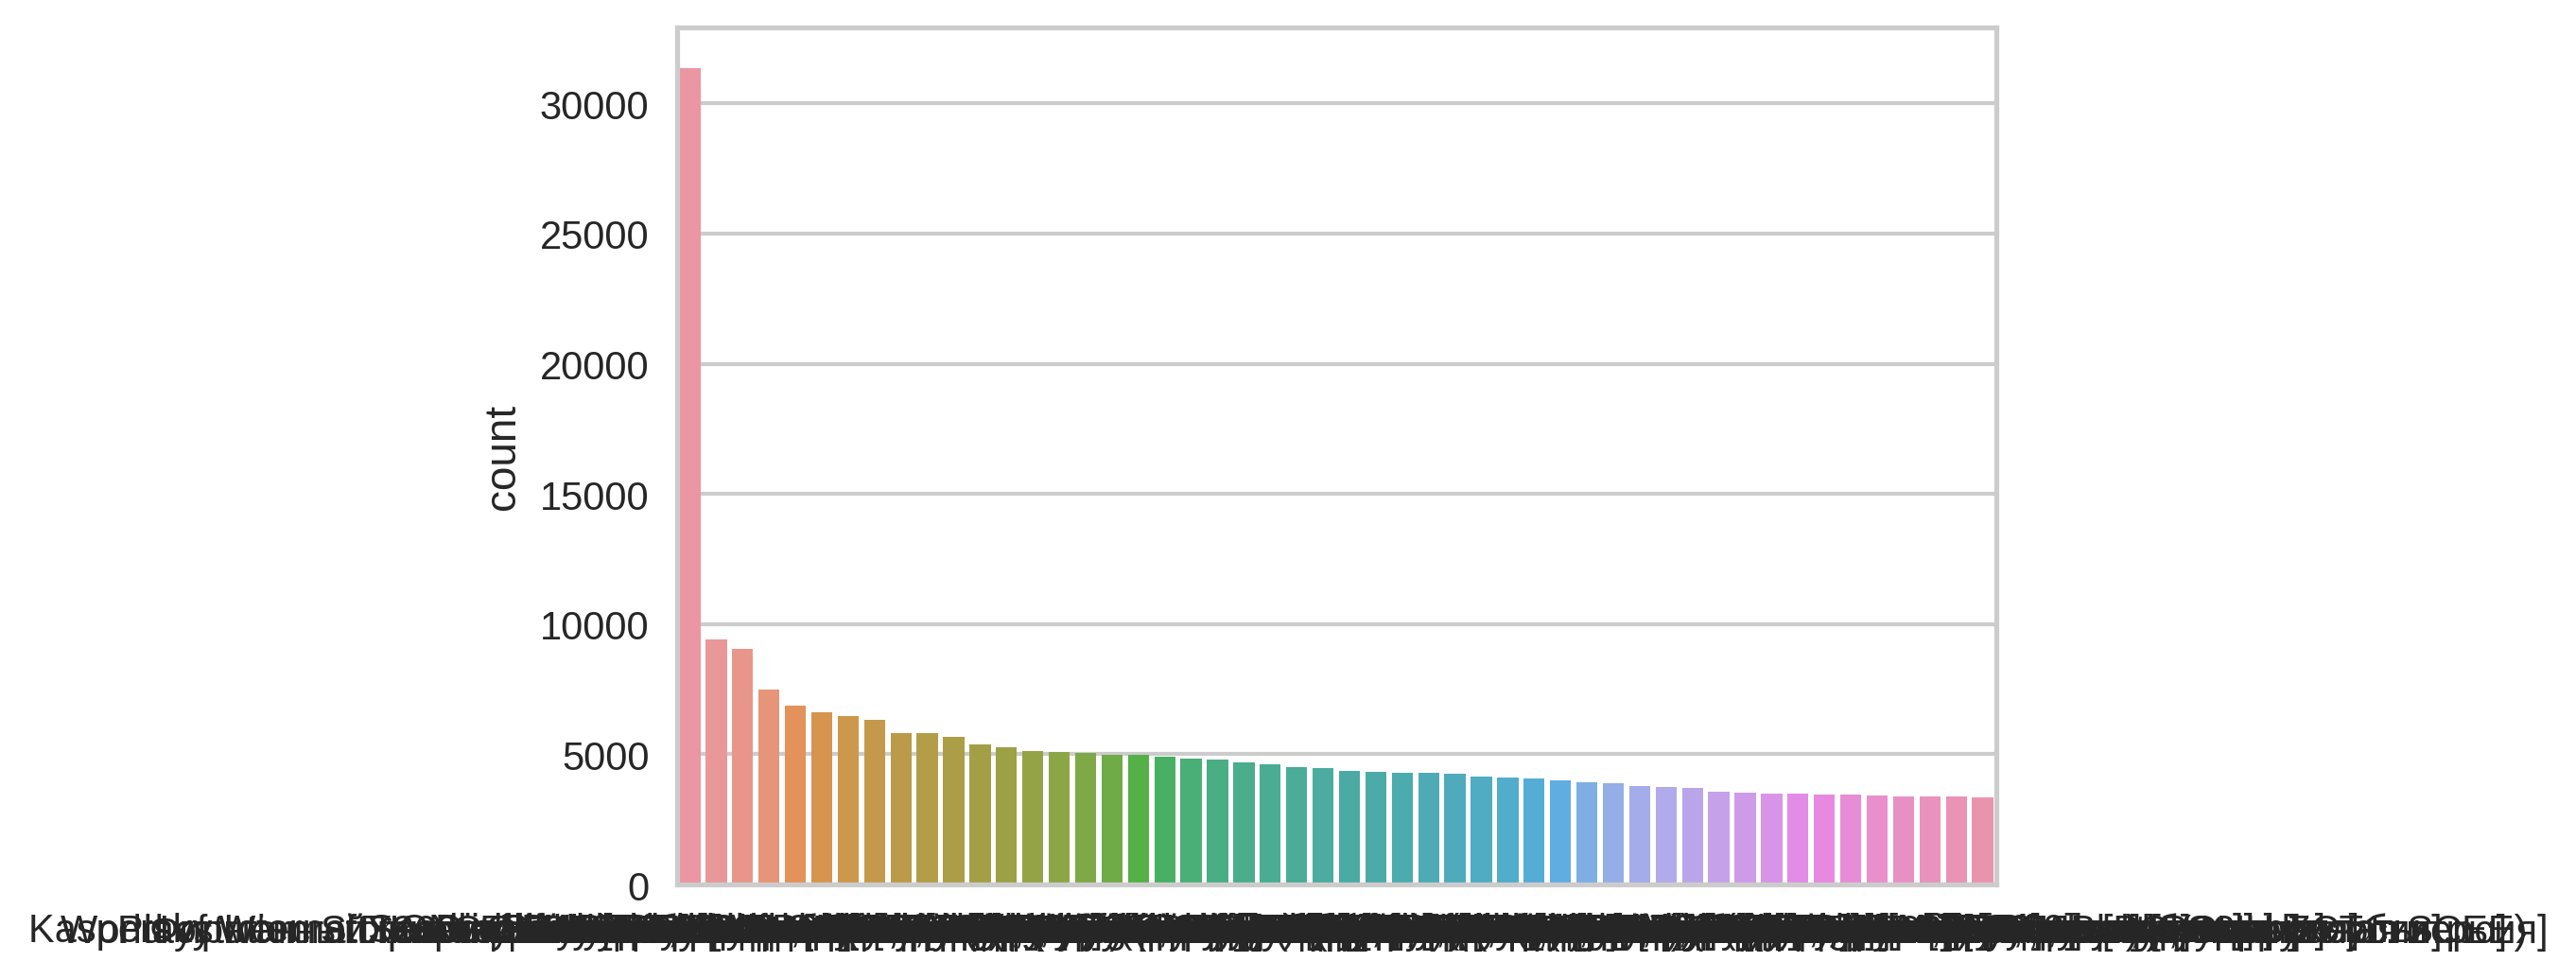

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), dpi=300)
sns.barplot(x="item_name", y='count', data=top_10_items)
ax.set_xlabel('')

**Top-10 popular categories:**

In [150]:
top_10_categories = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id') \
                                               .merge(item_categories_df, left_on='item_category_id', right_on='item_category_id')['item_category_name'] \
                                               .value_counts() \
                                               .reset_index()[:50]
            )
top_10_categories.columns = ['caterory_name', 'count']

In [151]:
top_10_categories.head(10)

,caterory_name,count
0,Кино - DVD,564652
1,Игры PC - Стандартные издания,351591
2,Музыка - CD локального производства,339585
3,Игры - PS3,208219
4,Кино - Blu-Ray,192674
5,Игры - XBOX 360,146789
6,Игры PC - Дополнительные издания,121539
7,Игры - PS4,79058
8,Подарки - Мягкие игрушки,53845
9,Подарки - Настольные игры (компактные),53227


Text(0.5, 0, '')

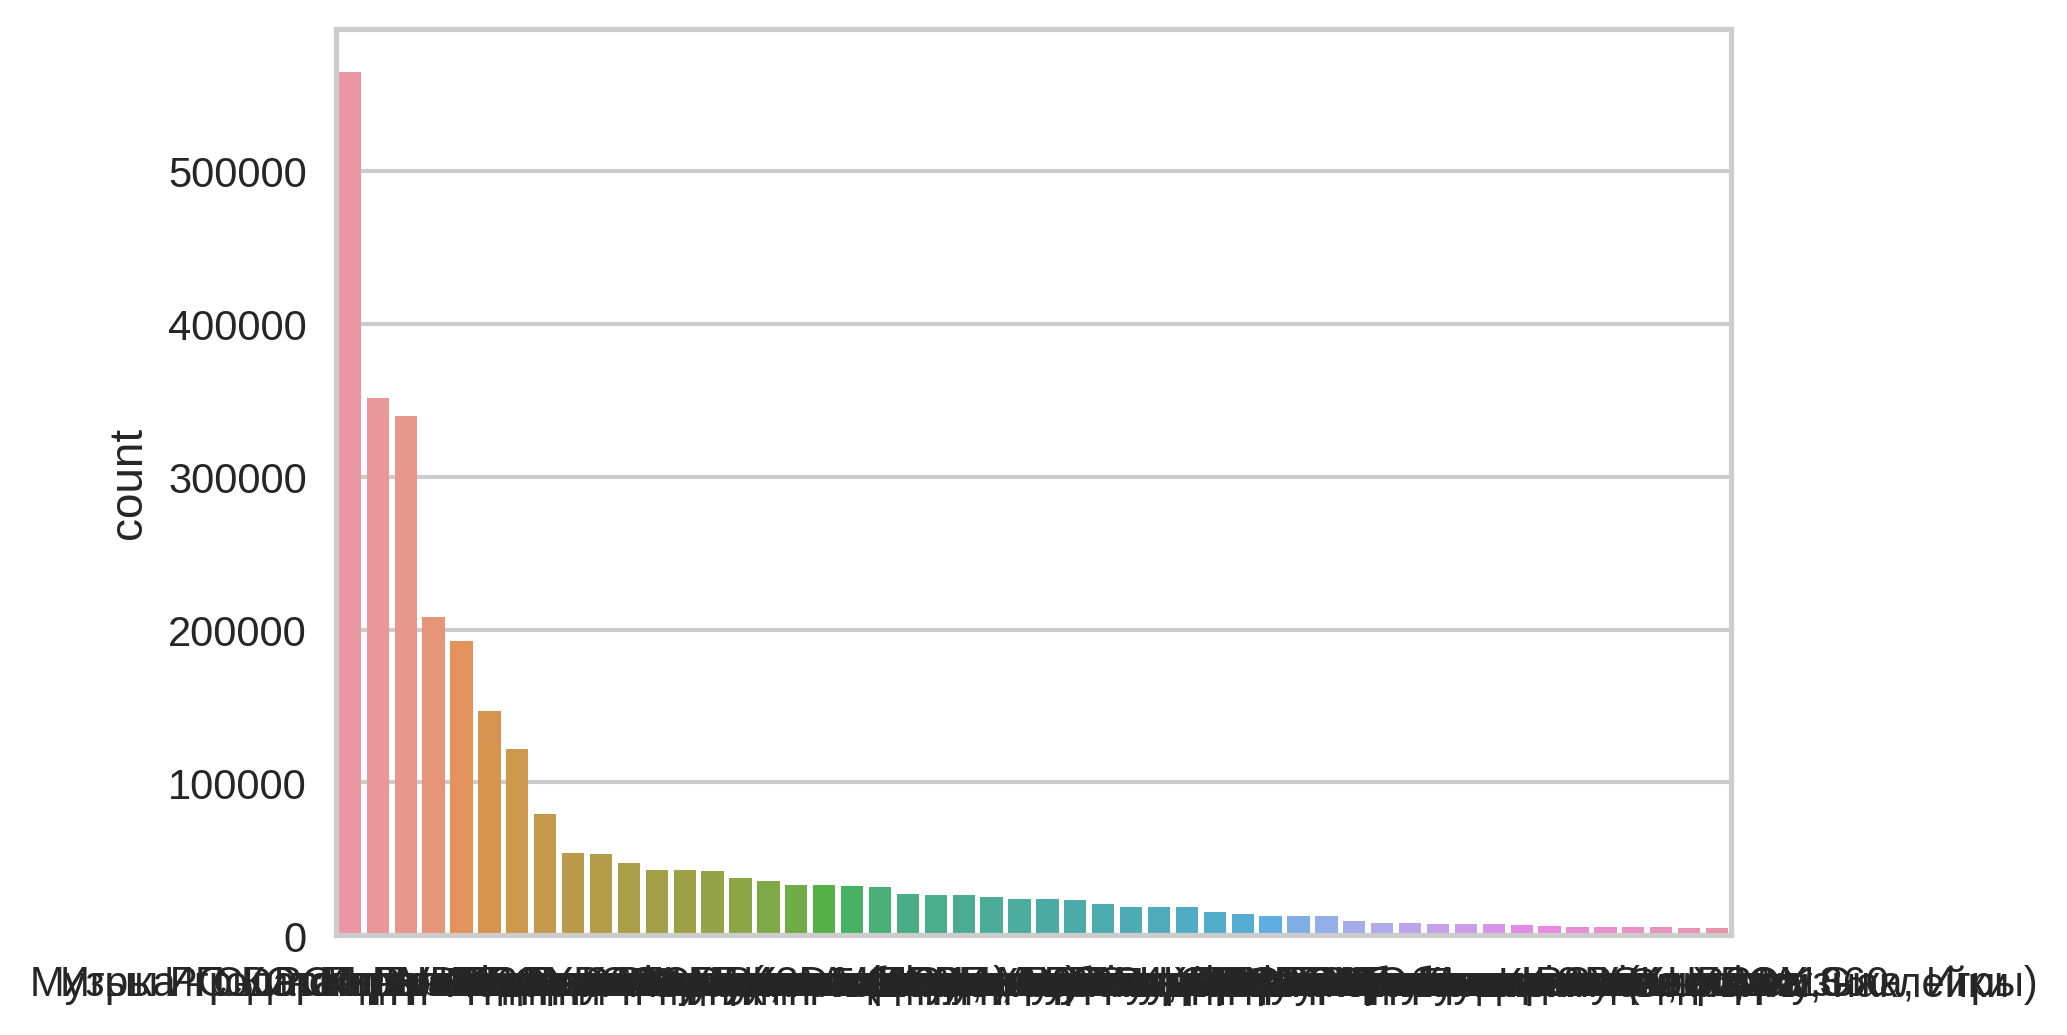

In [142]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), dpi=300)
sns.barplot(x="caterory_name", y='count', data=top_10_categories)
ax.set_xlabel('')

**Top-10 popular shops:**

In [147]:
top_10_shops = pd.DataFrame(sales_train_df.merge(shops_df, left_on='shop_id', right_on='shop_id')['shop_name'] \
                                          .value_counts() \
                                          .reset_index()[:50])
top_10_shops.columns = ['shop_name', 'count']

In [148]:
top_10_shops.head(10)

,shop_name,count
0,"Москва ТЦ ""Семеновский""",235636
1,"Москва ТРК ""Атриум""",186104
2,"Химки ТЦ ""Мега""",143480
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142234
4,"Якутск Орджоникидзе, 56",117428
5,"СПб ТК ""Невский Центр""",109253
6,"Москва ТЦ ""МЕГА Белая Дача II""",105366
7,"Воронеж (Плехановская, 13)",82663
8,"Якутск ТЦ ""Центральный""",71441
9,"Чехов ТРЦ ""Карнавал""",69573


Text(0.5, 0, '')

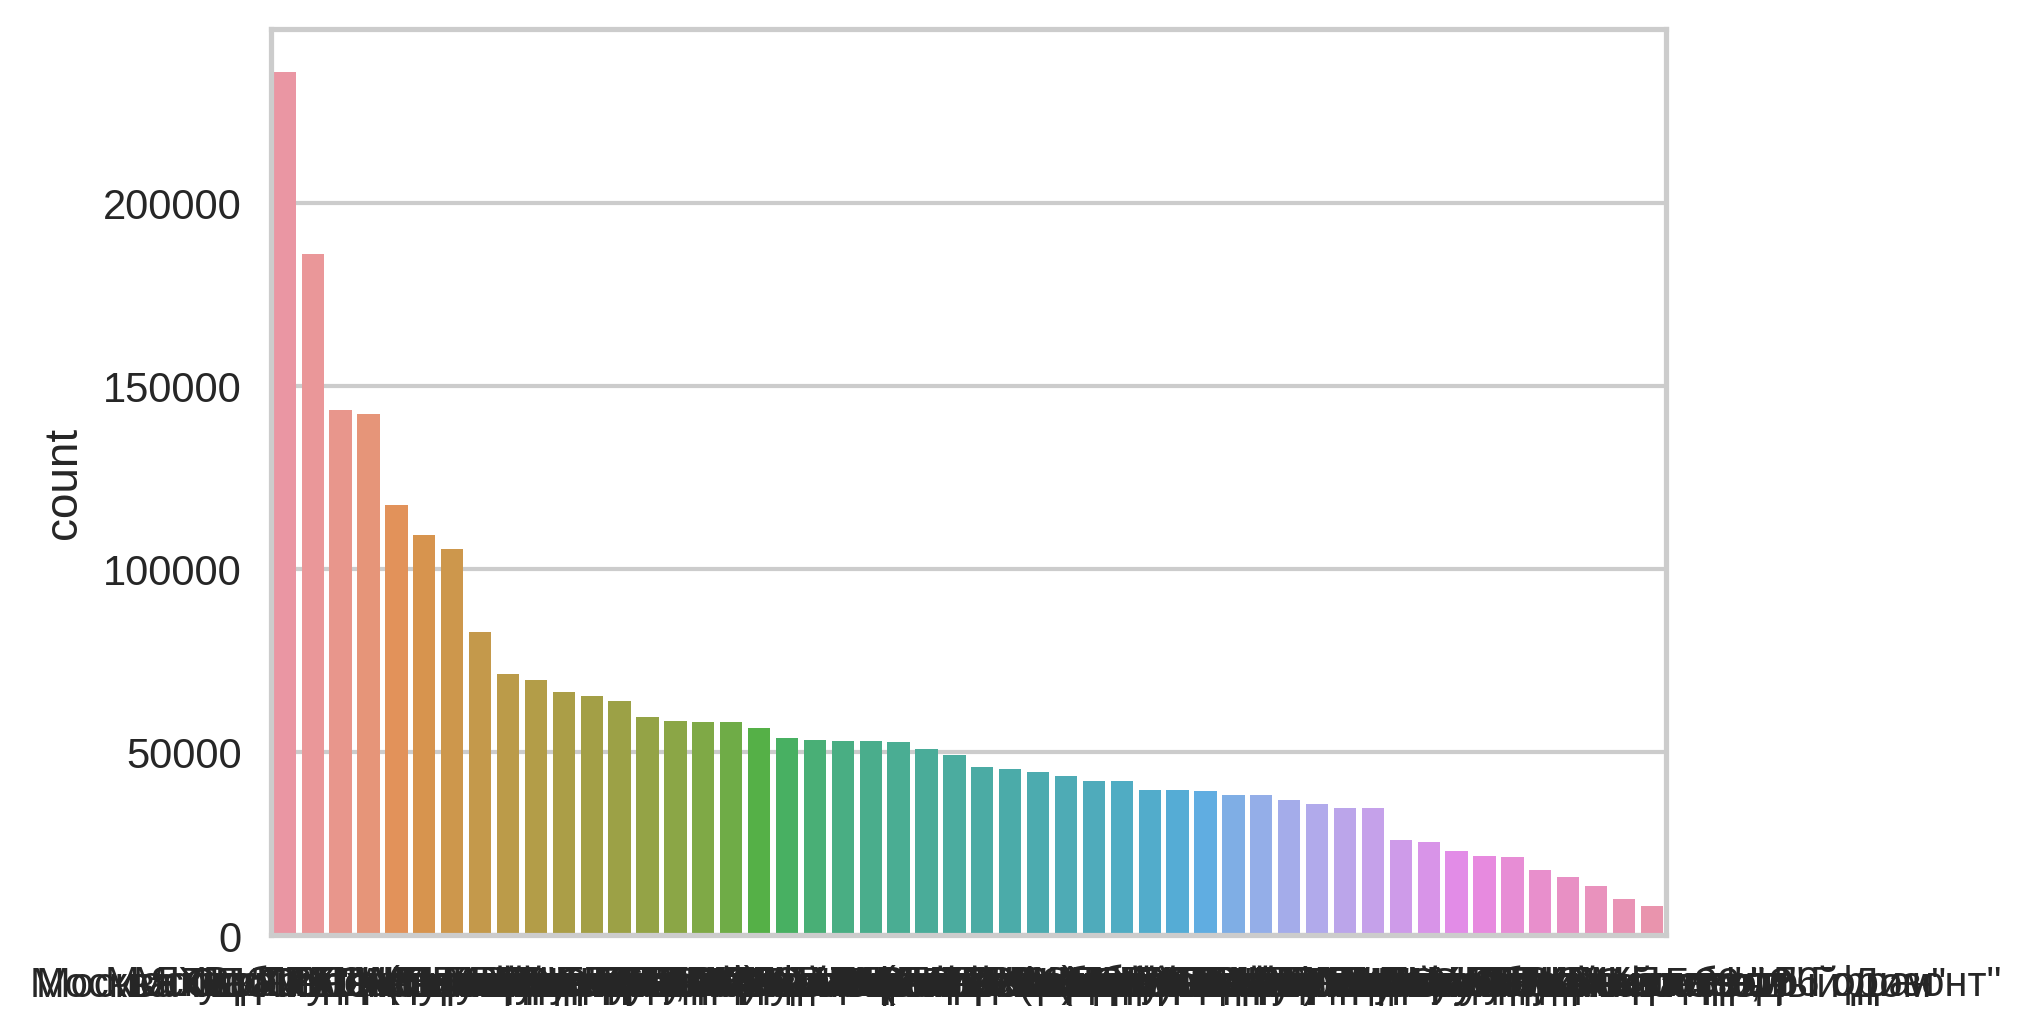

In [149]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), dpi=300)
sns.barplot(x="shop_name", y='count', data=top_10_shops)
ax.set_xlabel('')

# Basic data preparation

### 1.  Adding revenue column

In [22]:
# sales_train_df['revenue'] = sales_train_df['item_price'] * sales_train_df['item_cnt_day']

In [23]:
# sales_train_df.head()

### 2.  Date column to correct format

In [24]:
sales_train_df['date'] = sales_train_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

### 3.  Adding information about category

In [25]:
sales_train_df = sales_train_df.join(items_df, on='item_id', rsuffix='_').drop(['item_id_', 'item_name'], axis=1)

### 4.  Droping duplicates

In [26]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']

In [27]:
print('Duplicates: {}'.format(sales_train_df.duplicated(subset=subset).sum()))

Duplicates: 24


In [28]:
sales_train_df.drop_duplicates(subset=subset, inplace=True)

### 5.  Dropping shops and items not in test data

In [29]:
test_shops = test_df.shop_id.unique()
test_items = test_df.item_id.unique()

In [30]:
train = sales_train_df[sales_train_df.shop_id.isin(test_shops)]
train = sales_train_df[sales_train_df.item_id.isin(test_items)]

### 6.  Creating all combinations

In [31]:
from itertools import product

In [32]:
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])

In [33]:
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])

In [34]:
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
print('all_combi length = {}'.format(len(all_combi)))

all_combi length = 7282800


In [35]:
train = pd.merge(all_combi, sales_train_df, on=['date_block_num','shop_id','item_id'], how='left')

In [36]:
train['item_cnt_day'].fillna(0, inplace=True)

### 7.  Creating month sales table

In [37]:
train_month = train.groupby(['date_block_num','shop_id','item_id']) \
                   .agg({'item_cnt_day': ['sum','count']}) \
                   .reset_index()

In [38]:
train_month.columns = ['date_block_num','shop_id',
                       'item_id','item_cnt','item_order']

In [39]:
print(train_month[['item_cnt','item_order']].describe())

           item_cnt    item_order
count  7.282800e+06  7.282800e+06
mean   2.221345e-01  1.085718e+00
std    3.324564e+00  7.254517e-01
min   -4.000000e+00  1.000000e+00
25%    0.000000e+00  1.000000e+00
50%    0.000000e+00  1.000000e+00
75%    0.000000e+00  1.000000e+00
max    2.253000e+03  3.100000e+01


In [40]:
train_month['item_cnt'].clip(0, 20, inplace=True)

In [41]:
train_month.head()

,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.0,1
1,0,2,31,0.0,1
2,0,2,32,0.0,1
3,0,2,33,1.0,1
4,0,2,38,0.0,1


In [58]:
train_month.T

,0,1,2,3,4,5,6,7,8,9,...,7282790,7282791,7282792,7282793,7282794,7282795,7282796,7282797,7282798,7282799
date_block_num,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0
shop_id,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0
item_id,30.0,31.0,32.0,33.0,38.0,42.0,45.0,51.0,53.0,57.0,...,22118.0,22137.0,22139.0,22145.0,22154.0,22162.0,22163.0,22164.0,22166.0,22167.0
item_cnt,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_order,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 8.  Feature creation

In [45]:
item_group = item_categories_df['item_category_name'].apply(lambda x: str(x).split(' ')[0])

In [46]:
item_categories_df['item_group'] = pd.Categorical(item_group).codes

In [48]:
items_df = pd.merge(items_df,
                    item_categories_df.loc[:,['item_category_id','item_group']],
                    on=['item_category_id'], how='left')

In [50]:
item_group.unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [52]:
city = shops_df.shop_name.apply(lambda x: str.replace(x, '!', '')) \
                         .apply(lambda x: x.split(' ')[0])

In [54]:
shops_df['city'] = pd.Categorical(city).codes

In [55]:
city.unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)